In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from path_explain.path_explainer_tf import PathExplainerTF
from path_explain.utils import set_up_environment
from plot.scatter import scatter_plot
from plot.summary import summary_plot

from preprocess import heart_dataset

In [9]:
set_up_environment(visible_devices='3')

In [10]:
x_train, y_train, x_test, y_test, feature_names, x_train_un, x_test_un = heart_dataset()

In [11]:
total_df = pd.concat([x_train_un, x_test_un])

In [12]:
better_feature_names = [
    'age',
    'is male',
    'resting bp',
    'cholesterol (mg/dl)',
    'fasting blood sugar > 120 mg/dl',
    'max. achieved heart rate',
    'has excercise-induced angina',
    'st depression induced by exercise',
    'number of major vessels containing calcium',
    'experienced no chest pain',
    'experienced typical angina',
    'experienced atypical angina',
    'experienced non-anginal pain',
    'upsloping peak excercise ST',
    'flat peak excercise ST',
    'downsloping peak excercise ST',
    'thalassemia information missing',
    'thalassemia fixed defect',
    'no thalassemia (normal blood flow)',
    'thalassemia reversible defect',
    'resting ecg: normal',
    'resting ecg: st-t wave abnormality',
    'resting ecg: probable left vent. hypertrophy'
]

In [18]:
for i, feature_name in enumerate(feature_names):
    if feature_name[-2] == '_':
        print('{}:\t\t{} yes'.format(better_feature_names[i], total_df[feature_name].sum()))
    else:
        print('{}:\t\t{} +- {}'.format(better_feature_names[i], total_df[feature_name].mean(), total_df[feature_name].std()))

age:		54.51006711409396 +- 9.030526195216085
is male:		0.6778523489932886 +- 0.468085237508713
resting bp:		131.58053691275168 +- 17.669293411935975
cholesterol (mg/dl):		246.90604026845637 +- 51.89309683133054
fasting blood sugar > 120 mg/dl:		0.1476510067114094 +- 0.35535042554025886
max. achieved heart rate:		149.46644295302013 +- 22.983830096193152
has excercise-induced angina:		0.3288590604026846 +- 0.47058889992123754
st depression induced by exercise:		1.0553691275167785 +- 1.1641624052125834
number of major vessels containing calcium:		0.674496644295302 +- 0.9382019024458494
experienced no chest pain:		142 yes
experienced typical angina:		49 yes
experienced atypical angina:		84 yes
experienced non-anginal pain:		23 yes
upsloping peak excercise ST:		21 yes
flat peak excercise ST:		138 yes
downsloping peak excercise ST:		139 yes
thalassemia information missing:		2 yes
thalassemia fixed defect:		18 yes
no thalassemia (normal blood flow):		163 yes
thalassemia reversible defect:		11

In [60]:
df[np.logical_and(df['cp'] == 0, df['target'] == 1)].shape[0]

39

In [49]:
df[np.logical_and(df['cp'] == 0, df['target'] == 0)].shape[0]

104

In [50]:
df[np.logical_and(df['cp'] == 1, df['target'] == 1)].shape[0]

41

In [51]:
df[np.logical_and(df['cp'] == 1, df['target'] == 0)].shape[0]

9

In [54]:
df[np.logical_and(df['cp'] == 2, df['target'] == 1)].shape[0]

69

In [55]:
df[np.logical_and(df['cp'] == 2, df['target'] == 0)].shape[0]

18

In [54]:
df[np.logical_and(df['cp'] == 3, df['target'] == 1)].shape[0]

69

In [56]:
df[np.logical_and(df['cp'] == 3, df['target'] == 0)].shape[0]

7

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(23,)))
model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,  activation=None))
model.add(tf.keras.layers.Activation(tf.keras.activations.sigmoid))

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
                                                               decay_steps=1,
                                                               decay_rate=0.99,
                                                               staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(x_train, y_train, batch_size=242, epochs=200, verbose=0)
train_loss, train_accuracy, train_auc = model.evaluate(x_train, y_train, batch_size=51, verbose=0)
test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test, batch_size=51, verbose=0)

In [20]:
print('Train loss: {:.4f}\tTrain Accuracy: {:.4f}\tTrain AUC: {:.4f}'.format(train_loss, train_accuracy, train_auc))
print('Test loss: {:.4f}\tTest Accuracy: {:.4f}\tTest AUC: {:.4f}'.format(test_loss, test_accuracy, test_auc))

Train loss: 0.2574	Train Accuracy: 0.9118	Train AUC: 0.9617
Test loss: 0.3370	Test Accuracy: 0.8833	Test AUC: 0.9319


In [21]:
y_pred = model.predict(x_test)
y_pred_discrete = (y_pred > 0.5).astype(int)[:, 0]

tpr = np.sum(y_test[y_test == 1] == y_pred_discrete[y_test == 1]) / np.sum(y_test == 1)
tnr = np.sum(y_test[y_test == 0] == y_pred_discrete[y_test == 0]) / np.sum(y_test == 0)
print('True Positive Rate: {:.4f}\t True Negative Rate: {:.4f}'.format(tpr, tnr))

True Positive Rate: 0.8214	 True Negative Rate: 0.9375


In [22]:
explainer = PathExplainerTF(model)

In [23]:
all_data = np.concatenate([x_train, x_test], axis=0)

In [24]:
attributions = explainer.attributions(inputs=all_data,
                                      baseline=x_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 298/298 [00:01<00:00, 165.02it/s]


In [25]:
interactions = explainer.interactions(inputs=all_data,
                                      baseline=x_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 298/298 [05:36<00:00,  1.13s/it]


In [26]:
all_data_renorm = np.concatenate([x_train_un, x_test_un])

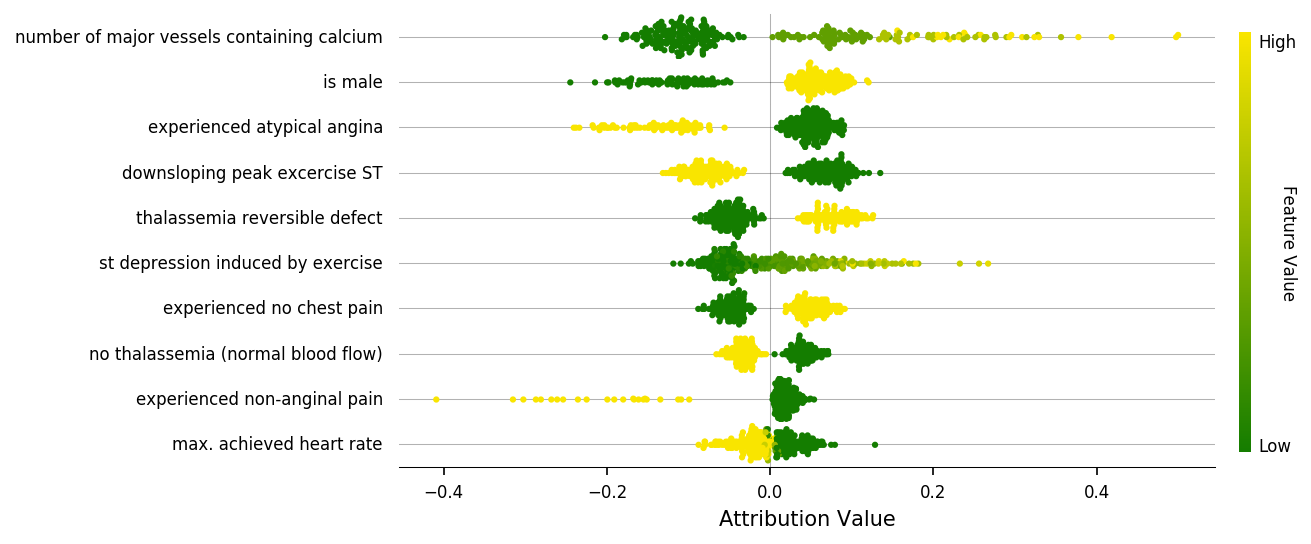

In [27]:
summary_plot(attributions,
             all_data_renorm,
             interactions=None,
             interaction_feature=None,
             feature_names=better_feature_names,
             plot_top_k=10)
plt.savefig('heart_disease_summary.pdf')

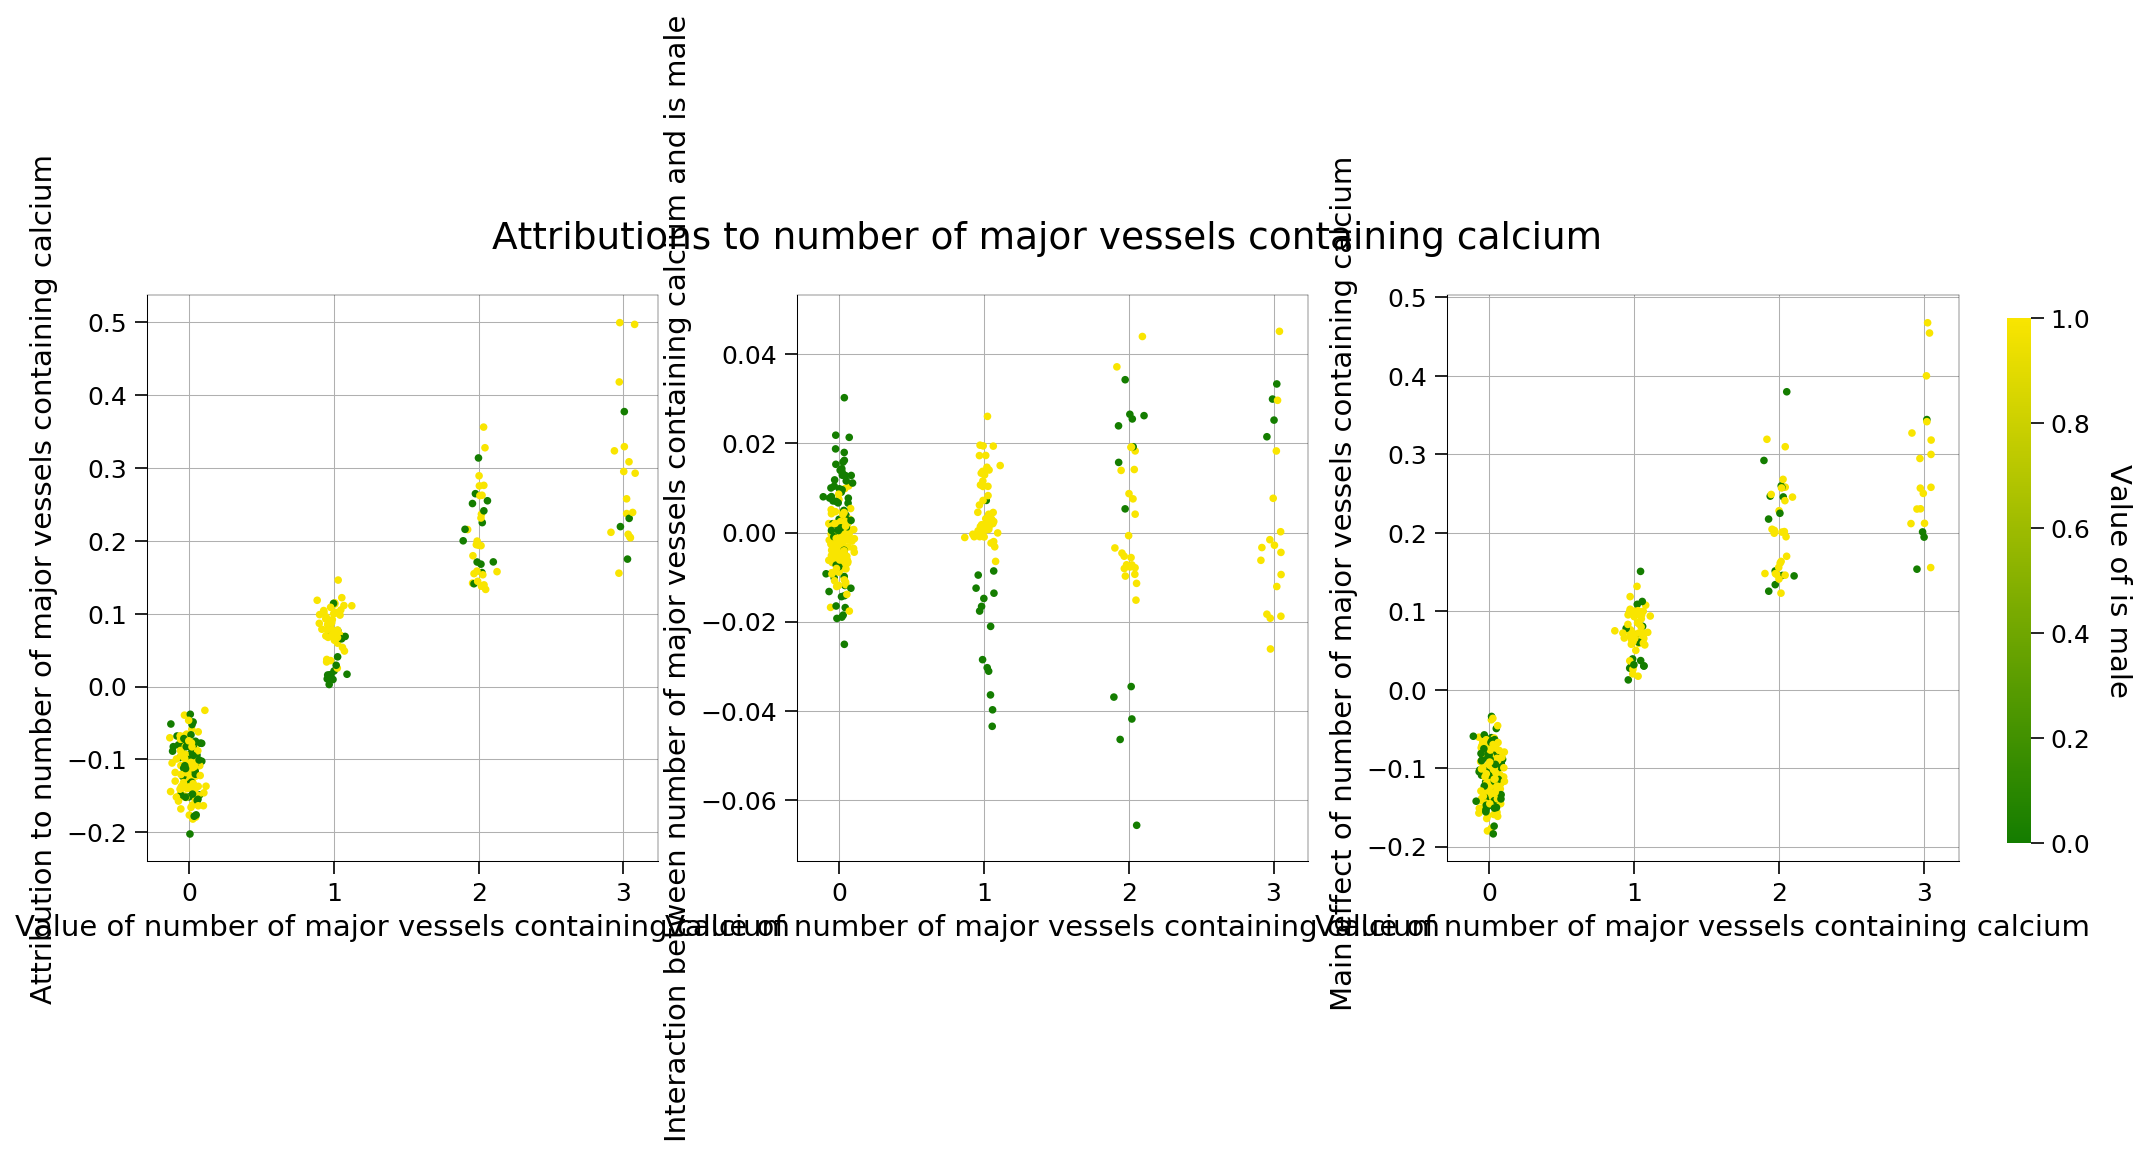

In [61]:
fig, axs = scatter_plot(attributions,
                        all_data_renorm,
                        feature_index='number of major vessels containing calcium',
                        interactions=interactions,
                        color_by='is male',
                        feature_names=better_feature_names,
                        scale_y_ind=True,
                        add_random_noise_x=True)
plt.savefig('major_vessels.pdf')

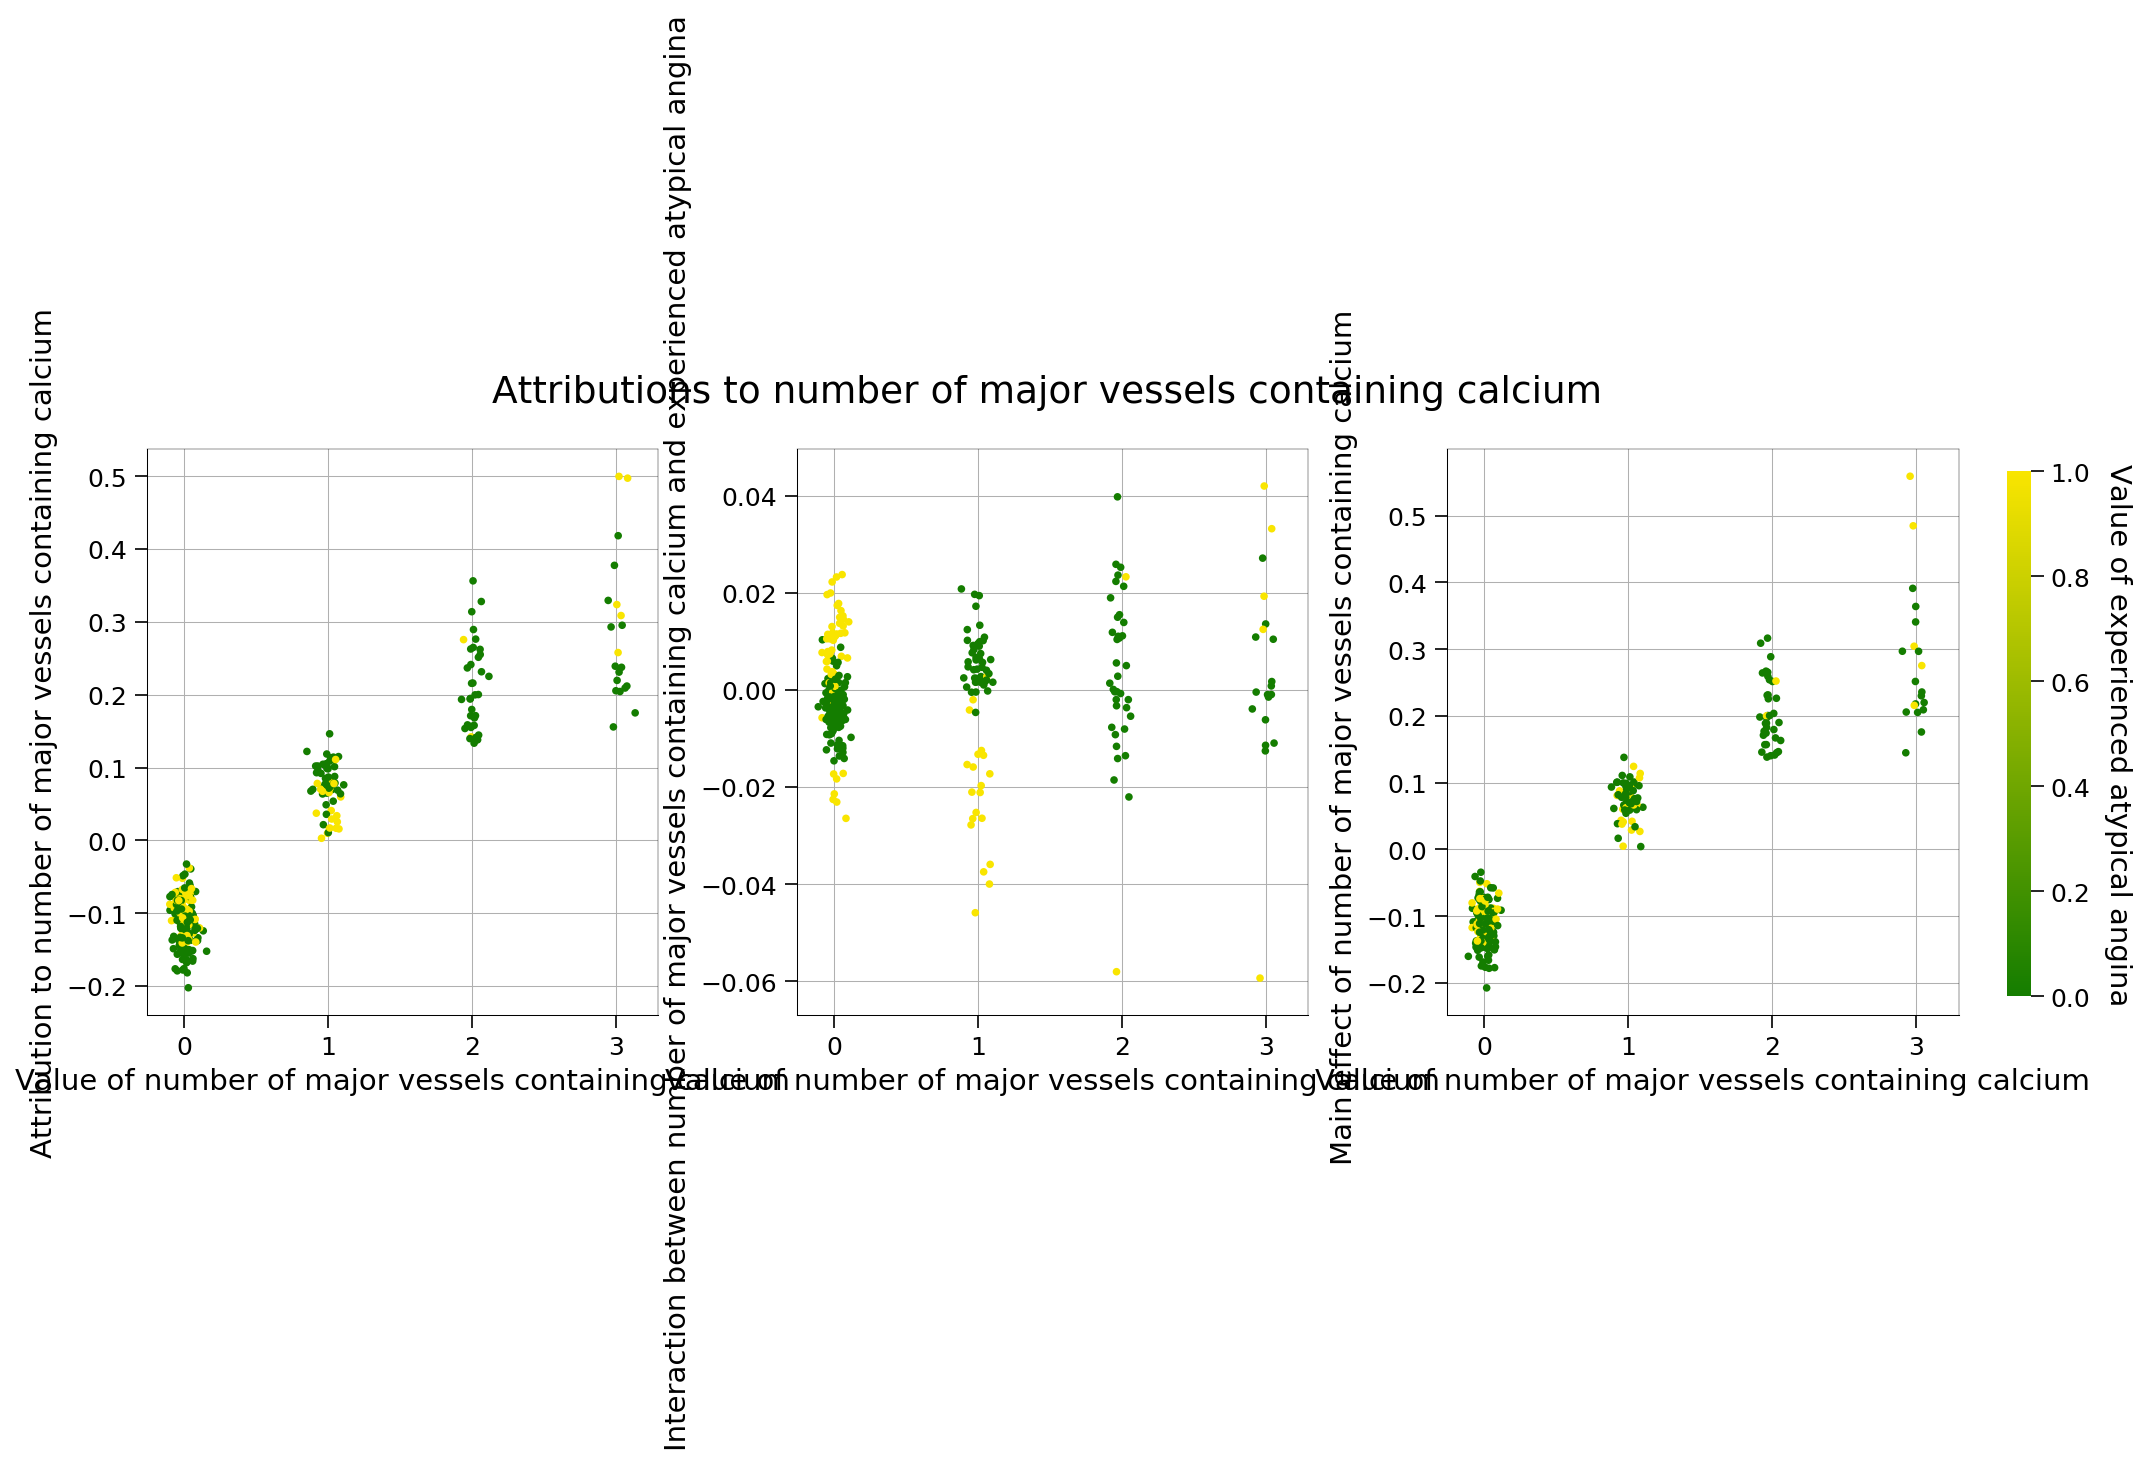

In [28]:
fig, axs = scatter_plot(attributions,
                        all_data_renorm,
                        feature_index='number of major vessels containing calcium',
                        interactions=interactions,
                        color_by='experienced atypical angina',
                        feature_names=better_feature_names,
                        scale_y_ind=True,
                        add_random_noise_x=True)
plt.savefig('major_vessels.pdf')

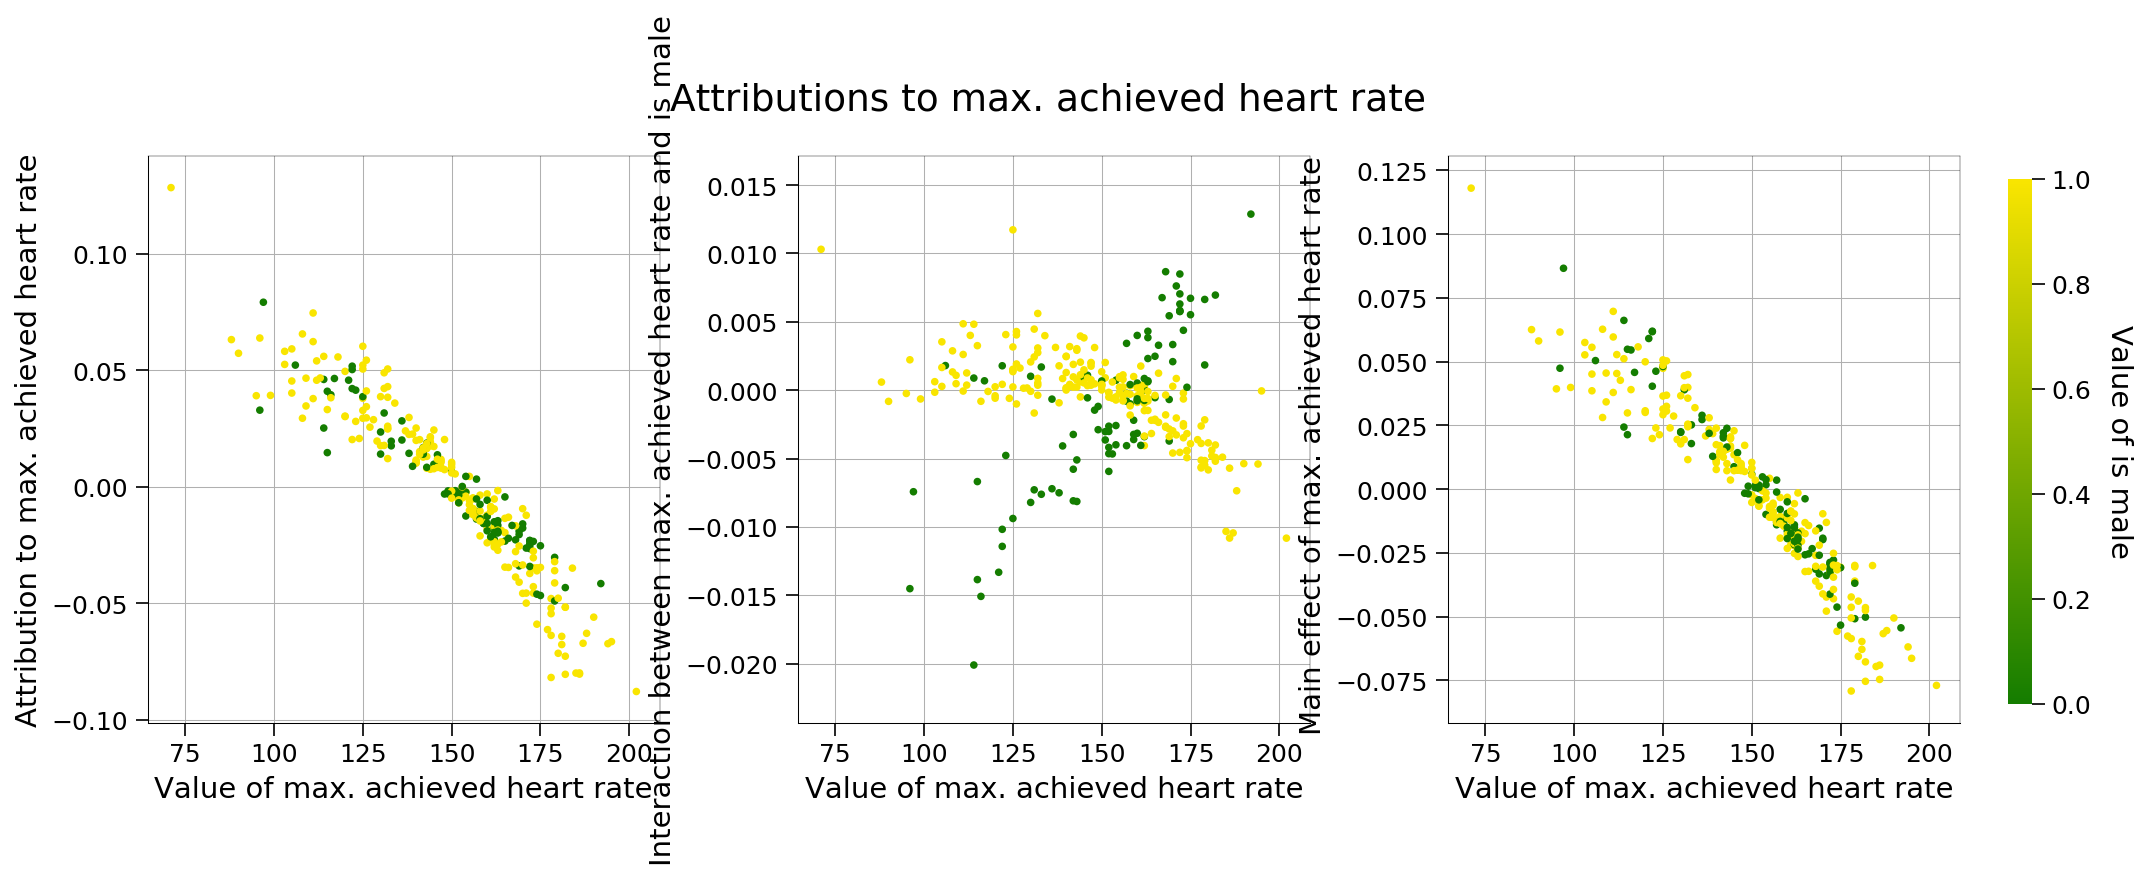

In [62]:
fig, axs = scatter_plot(attributions,
                        all_data_renorm,
                        feature_index='max. achieved heart rate',
                        interactions=interactions,
                        color_by='is male',
                        feature_names=better_feature_names,
                        scale_y_ind=True)
plt.savefig('max_heart_rate.pdf')

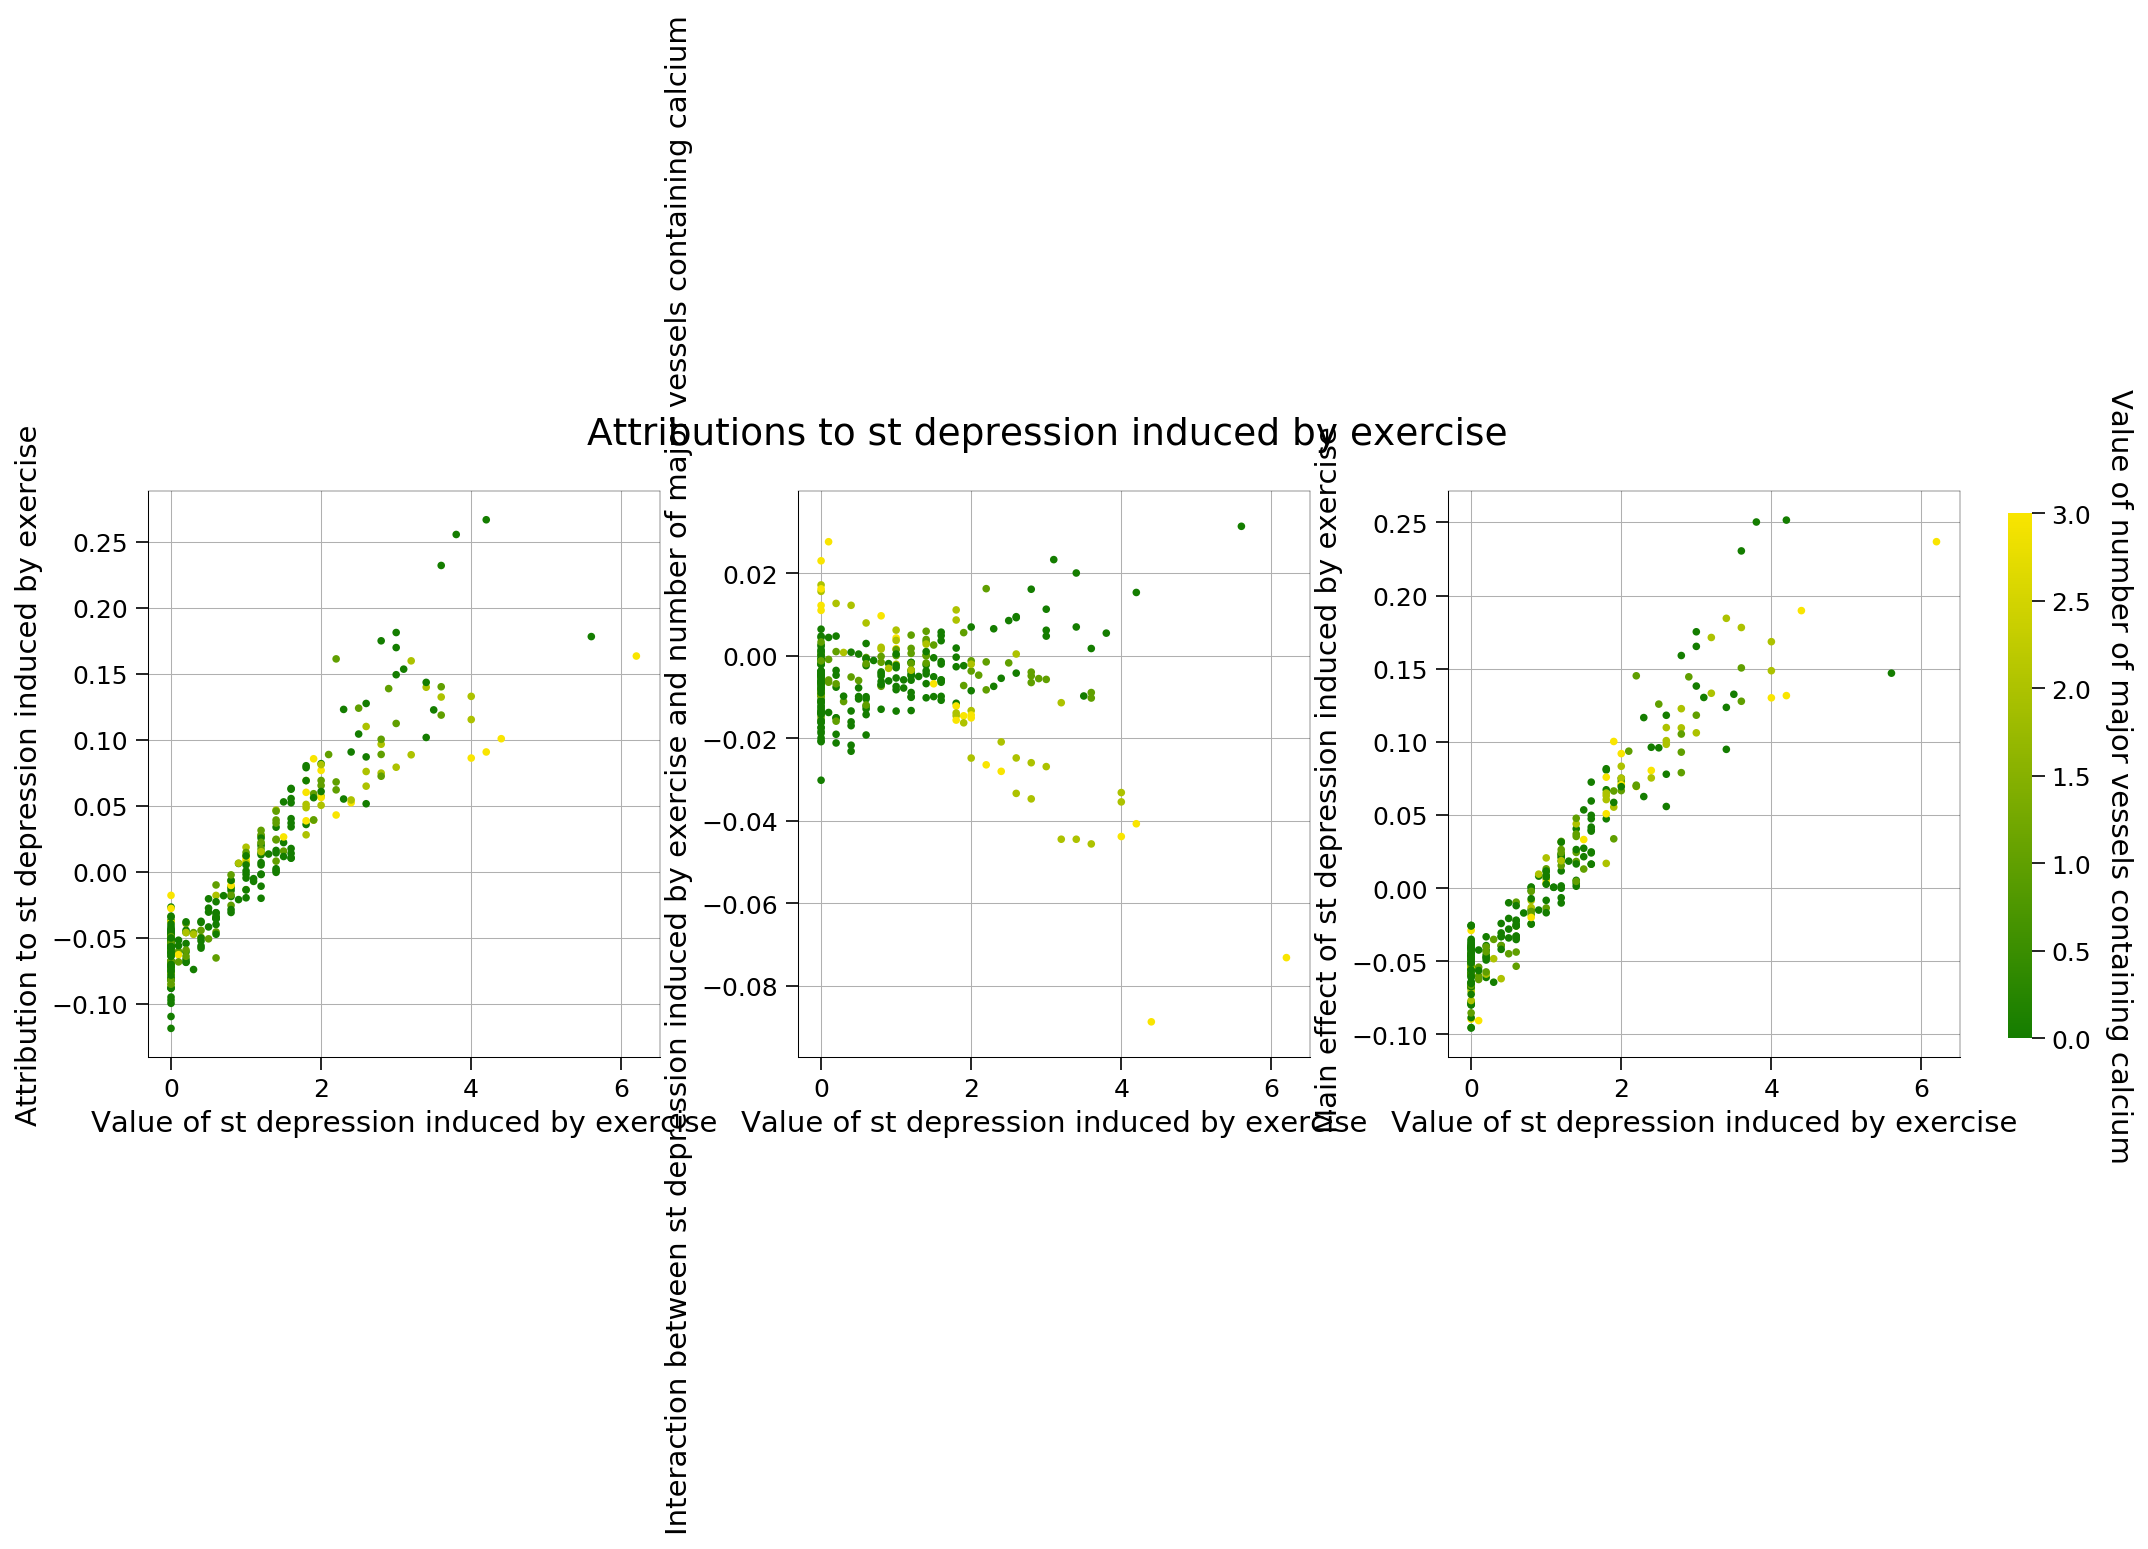

In [63]:
fig, axs = scatter_plot(attributions,
                        all_data_renorm,
                        feature_index='st depression induced by exercise',
                        interactions=interactions,
                        color_by='number of major vessels containing calcium',
                        feature_names=better_feature_names,
                        scale_y_ind=True)
plt.savefig('st_depression.pdf')